In [1]:
# Import packages
import sys
!{sys.executable} -m pip install world_bank_data
!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install geopy
import pandas as pd
import world_bank_data as wb
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import calendar
import seaborn as sns
from decimal import Decimal
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy import distance
import plotly as py
import plotly.graph_objects as go
import ipywidgets
from ipywidgets import widgets
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### 1. Get Data from John Hopkins 

In [12]:
# Loading Covid 19 Data
public_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
corona_data = pd.read_csv(public_url)
corona_data.drop(['Lat','Long','Province/State'],axis=1)
countries = sorted(corona_data['Country/Region'].unique())
country_data = corona_data.groupby('Country/Region').sum()
country_data = country_data.drop(['Lat','Long'],axis=1)
country_data = country_data.rename(columns={'Country/Region':'Country'},index={'US':'United States'})

### 2. Get Data from the World Bank

In [13]:
# Get GDP data
GDP = pd.DataFrame(wb.get_series('NY.GDP.MKTP.CD',mrv=1))
GDP = GDP.droplevel(level=[1,2]) # Droping multi level indexing

# Get gini Index
Gini = pd.DataFrame(wb.get_series('SI.POV.GINI',date = '2010'))
Gini = Gini.droplevel(level=[1,2]) # Droping multi level indexing

# Get population data
Pop = pd.DataFrame(wb.get_series('SP.POP.TOTL',mrv=1))
Pop = Pop.droplevel(level=[1,2]) # Droping multi level indexing

# Get Health System Data
Health = pd.DataFrame(wb.get_series('SH.MED.BEDS.ZS',date = '2010'))
Health = Health.droplevel(level=[1,2]) # Droping multi level indexing

# Get Density Data
Dens = pd.DataFrame(wb.get_series('EN.POP.DNST',mrv=1))
Dens = Dens.droplevel(level=[1,2])

# Get Trade data
Trade = pd.DataFrame(wb.get_series('NE.TRD.GNFS.ZS',mrv=1))
Trade = Trade.droplevel(level=[1,2])

#Get total number of cases 
Total = pd.DataFrame(country_data.sum(axis=1), columns=['Total'])


### Religion Data

In [14]:
religion = pd.read_excel('religious-diversity-index.xlsx')
religion = religion.set_index('Country')
religion = religion.drop('2010 Country Population',axis = 1)
religion = religion.replace('< 0.1%',0) # Smaller than 0.1 % is transformed to zero
temp = religion.drop('RDI',axis=1).idxmax(axis=1)
MainReligion = temp.replace(temp.unique(),
                ['Muslim','Christian','Buddhist','Unaffiliated'
                 ,'Hindu','Jewish','Folk'])
religion['Main Religion'] = MainReligion
religion = religion.drop(temp.unique(),axis=1)
religion = religion.drop('Percent Other Religions',axis=1)

RDI score, higher diversity

### Downloaded Data

In [15]:
# Economist businnes unit
df = pd.read_excel('_EIU-Democracy Indices - Dataset - v3.xlsx')
year = df['time'] == 2018
DEM = df[year]
DEM = DEM.drop(['geo','a','b','c','d','e','time','f'],axis = 1)
DEM = DEM.set_index('name')
DEM = DEM.rename(columns={'name':'Country'})

# Continent data
Cont = pd.read_csv('Countries-Continents.csv')
Cont = Cont.set_index('Country')
Cont = Cont.rename(index={'US':'United States'})

### 4. Merge all data

In [16]:
allData = country_data.join([Total,GDP,Gini,DEM,Pop,Health,Dens,Trade,religion,Cont])
allData.rename(columns={'NY.GDP.MKTP.CD':'GDP',
                          'SI.POV.GINI':'Gini',
                          'Democracy index (EIU)':'Dem',
                       'SP.POP.TOTL':'Pop',
                       'SH.MED.BEDS.ZS': 'Health',
                       'EN.POP.DNST':'Dens',
                       'NE.TRD.GNFS.ZS':'Trade'
                      },inplace=True)
allData = allData.dropna()

### Getting distances between countries

In [17]:
geolocator = Nominatim(user_agent="my-application")

In [18]:
Distance = []
count=0
countries = list(allData.index)
Wuhan = geolocator.geocode("Wuhan")
Wuhan = (Wuhan.latitude, Wuhan.longitude)

In [19]:
for i in countries[0:16]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1

In [20]:
for i in countries[16:33]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1

In [21]:
for i in countries[33:45]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1

In [22]:
for i in countries[45:59]:
    c = geolocator.geocode(i)
    Distance.append(distance.distance((c.latitude, c.longitude), Wuhan).km)
    count += 1

In [23]:
Distances = pd.DataFrame(Distance, index =list(allData.index),columns =['Distance'])

In [24]:
allData = allData.join(Distances)

### 5. Class imbalances

In [15]:
#Religion
Religion_counts = allData['Main Religion'].value_counts()
print(Religion_counts)

Christian       47
Muslim           6
Buddhist         2
Unaffiliated     2
Folk             1
Jewish           1
Name: Main Religion, dtype: int64


In [16]:
def count(myclass,data):
    q = np.linspace(0,1,11)
    quantile = np.array(data[myclass].quantile(q))
    count = np.zeros((10,1)).reshape(-1,1)
    for j in range(10):
        subset_count =  (quantile[j] <= data[myclass]) & (data[myclass] < quantile[j+1])
        count[j] = data[myclass][subset_count].count()

    for i, c in enumerate(count):
        print('# quantile',myclass,'%.2E' % Decimal(quantile[1:11][i]),'=',c) 

In [17]:
num_cols=['GDP','Gini','Dem','Pop','Health','Dens','Trade','RDI','Distance']
#GDP
count(num_cols[0],allData)

# quantile GDP 2.27E+10 = [6.]
# quantile GDP 3.29E+10 = [6.]
# quantile GDP 5.62E+10 = [6.]
# quantile GDP 7.38E+10 = [6.]
# quantile GDP 2.18E+11 = [5.]
# quantile GDP 3.07E+11 = [6.]
# quantile GDP 4.85E+11 = [6.]
# quantile GDP 7.32E+11 = [6.]
# quantile GDP 1.79E+12 = [6.]
# quantile GDP 2.05E+13 = [5.]


In [18]:
#Gini
count(num_cols[1],allData)

# quantile Gini 2.77E+01 = [5.]
# quantile Gini 2.96E+01 = [7.]
# quantile Gini 3.17E+01 = [6.]
# quantile Gini 3.31E+01 = [6.]
# quantile Gini 3.41E+01 = [5.]
# quantile Gini 3.54E+01 = [6.]
# quantile Gini 3.91E+01 = [6.]
# quantile Gini 4.29E+01 = [6.]
# quantile Gini 4.72E+01 = [6.]
# quantile Gini 5.56E+01 = [5.]


In [19]:
#Dem
count(num_cols[2],allData)

# quantile Dem 4.33E+01 = [6.]
# quantile Dem 5.62E+01 = [6.]
# quantile Dem 6.25E+01 = [6.]
# quantile Dem 6.55E+01 = [6.]
# quantile Dem 7.03E+01 = [5.]
# quantile Dem 7.69E+01 = [6.]
# quantile Dem 7.97E+01 = [6.]
# quantile Dem 8.44E+01 = [6.]
# quantile Dem 9.14E+01 = [6.]
# quantile Dem 9.87E+01 = [5.]


In [20]:
#Pop
count(num_cols[3],allData)

# quantile Pop 2.04E+06 = [6.]
# quantile Pop 3.62E+06 = [6.]
# quantile Pop 5.63E+06 = [6.]
# quantile Pop 8.85E+06 = [6.]
# quantile Pop 1.02E+07 = [5.]
# quantile Pop 1.60E+07 = [6.]
# quantile Pop 2.97E+07 = [6.]
# quantile Pop 5.22E+07 = [6.]
# quantile Pop 8.54E+07 = [6.]
# quantile Pop 1.39E+09 = [5.]


In [21]:
#Health
count(num_cols[4],allData)

# quantile Health 1.20E+00 = [5.]
# quantile Health 1.76E+00 = [7.]
# quantile Health 2.58E+00 = [6.]
# quantile Health 3.04E+00 = [6.]
# quantile Health 3.56E+00 = [5.]
# quantile Health 4.46E+00 = [6.]
# quantile Health 5.32E+00 = [6.]
# quantile Health 6.24E+00 = [6.]
# quantile Health 7.20E+00 = [5.]
# quantile Health 1.15E+01 = [6.]


In [22]:
#Dens
count(num_cols[5],allData)

# quantile Dens 1.59E+01 = [6.]
# quantile Dens 2.50E+01 = [6.]
# quantile Dens 4.58E+01 = [6.]
# quantile Dens 7.10E+01 = [6.]
# quantile Dens 8.57E+01 = [5.]
# quantile Dens 1.07E+02 = [6.]
# quantile Dens 1.24E+02 = [6.]
# quantile Dens 1.71E+02 = [6.]
# quantile Dens 2.75E+02 = [6.]
# quantile Dens 1.51E+03 = [5.]


In [23]:
#Trade
count(num_cols[6],allData)

# quantile Trade 4.32E+01 = [6.]
# quantile Trade 6.03E+01 = [6.]
# quantile Trade 6.65E+01 = [6.]
# quantile Trade 7.60E+01 = [6.]
# quantile Trade 8.70E+01 = [5.]
# quantile Trade 9.75E+01 = [6.]
# quantile Trade 1.10E+02 = [6.]
# quantile Trade 1.26E+02 = [6.]
# quantile Trade 1.63E+02 = [6.]
# quantile Trade 3.87E+02 = [5.]


In [24]:
#RDI
count(num_cols[7],allData)

# quantile RDI 6.00E-01 = [5.]
# quantile RDI 1.10E+00 = [6.]
# quantile RDI 1.58E+00 = [7.]
# quantile RDI 2.42E+00 = [6.]
# quantile RDI 3.10E+00 = [5.]
# quantile RDI 3.50E+00 = [4.]
# quantile RDI 4.34E+00 = [8.]
# quantile RDI 5.18E+00 = [6.]
# quantile RDI 5.70E+00 = [5.]
# quantile RDI 7.70E+00 = [6.]


### 6. Plots

a. Confirmed Cases

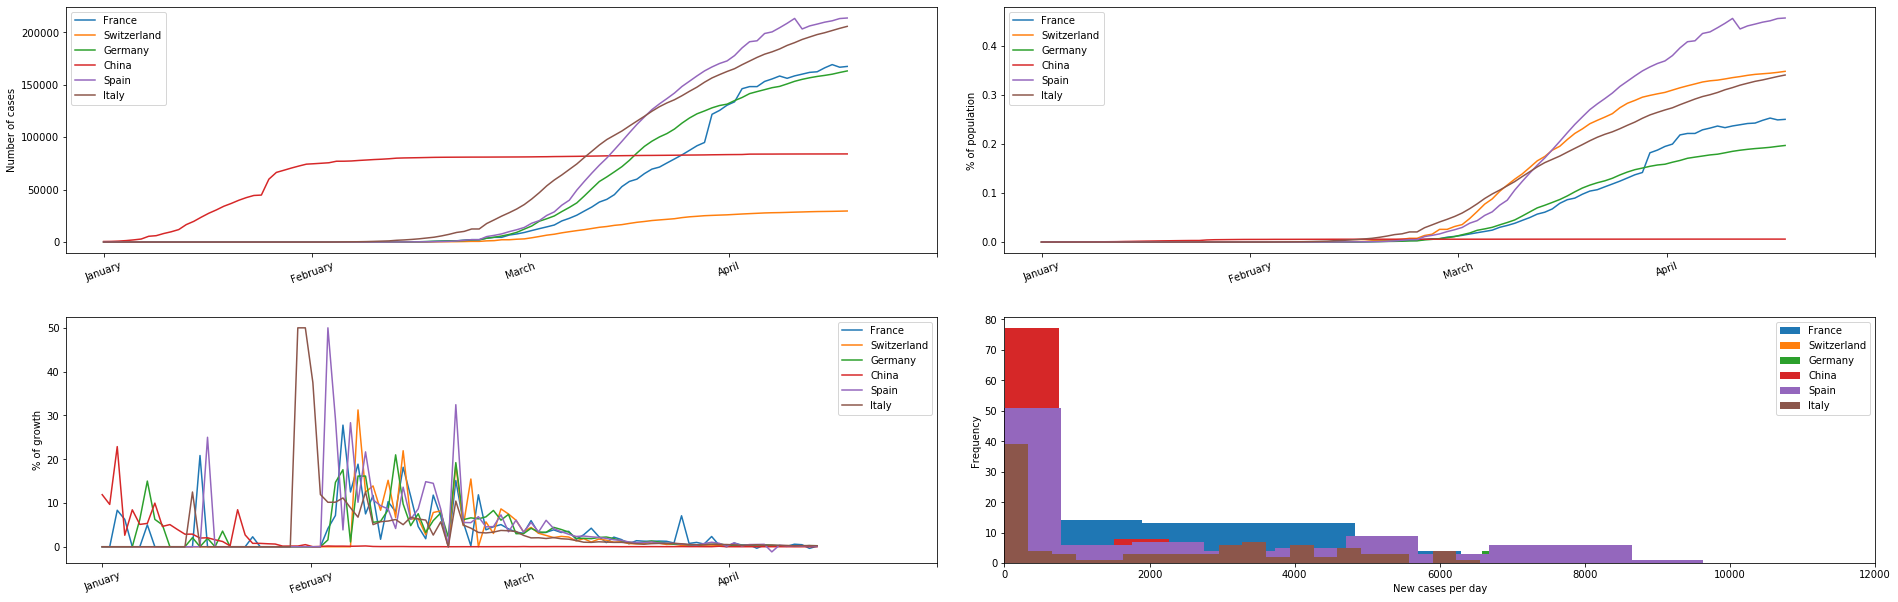

In [25]:
countries = ['France','Switzerland','Germany','China','Spain','Italy']

fig = plt.figure(figsize=(27,9))
plt.subplot(221)
for country in countries:
    toplot = country_data.loc[country,:]
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('Number of cases')
plt.subplot(222)
for country in countries:
    toplot = country_data.loc[country,:]/allData.loc[country,'Pop']*100
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('% of population')
plt.subplot(223)
for country in countries:
    toplot = []
    for time in range(len(country_data.columns)-4):
        if country_data.loc[country,country_data.columns[time]] != 0:
            for flat in range(0,4): 
                meanGrowth = 0
                Growth = (country_data.loc[country,country_data.columns[time+1+flat]]/
                      country_data.loc[country,country_data.columns[time+flat]] - 1)*100
                meanGrowth = meanGrowth + Growth
                if meanGrowth > 200:
                    meanGrowth = 200
            toplot.append(meanGrowth/4)
        else:
            toplot.append(0)
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('% of growth')
plt.subplot(224)
for country in countries:
    toplot = []
    for time in range(len(country_data.columns)-1):
        toplot.append(country_data.loc[country,country_data.columns[time+1]]-
        country_data.loc[country,country_data.columns[time]])
    plt.hist(toplot,bins=20)
plt.legend(countries)
plt.xlim([0,12000])
#plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('Frequency')
plt.xlabel('New cases per day')
fig.tight_layout(pad=3.0)
plt.show()


### Interactive Graphs

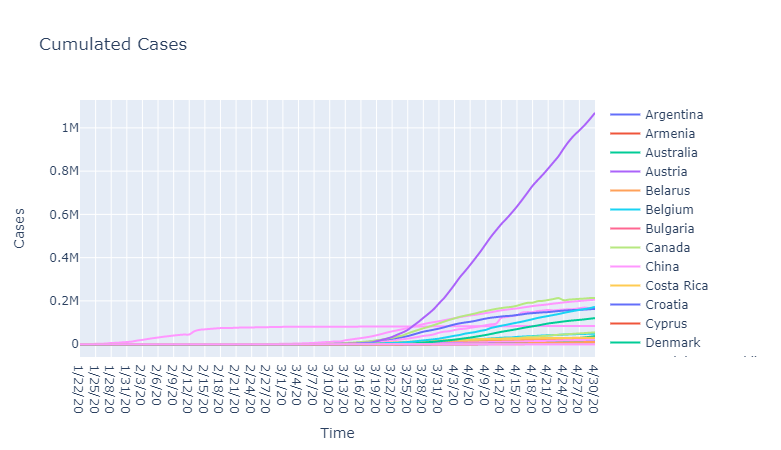

In [41]:
from scipy import special
countries = list(allData.index)
 
def update_plot(signals):
      
    data=[]  
    for country in countries:
        layout = go.Layout(
            title = 'Cumulated Cases',
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Time'
                )
            )
    
        trace1 = go.Scatter(
            x = allData.columns,
            y = country_data.loc[country,:],
            mode = 'lines',
            name = country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)

    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

signals = widgets.Dropdown(options=countries, value = 'Argentina', description='Country')
widgets.interactive(update_plot, signals=signals)

In [42]:
country_day = country_data.diff(axis=1)

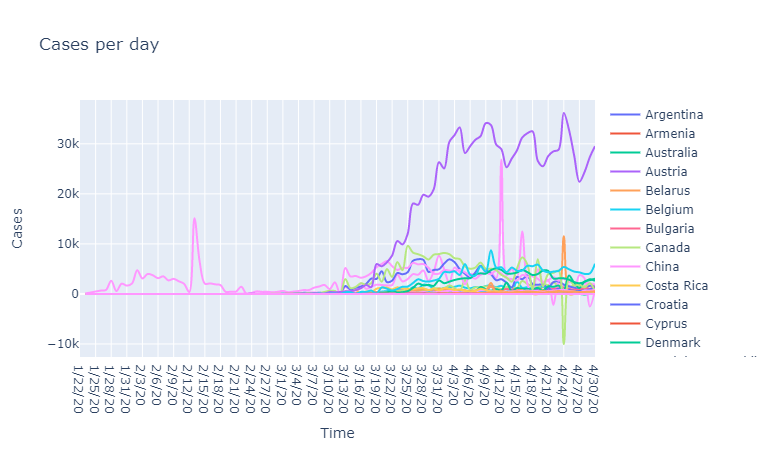

In [43]:
def update_plots(signal):
      
    data=[]  
    for country in countries:
        layout = go.Layout(
            title = 'Cases per day',
            yaxis = dict(
                title = 'Cases'
                ),
            xaxis = dict(
                title = 'Time'
                )
            )
    
        trace1 = go.Scatter(
            x = allData.columns,
            y = country_day.loc[country,:],
            mode = 'lines',
            name = country,
            line = dict(
                shape = 'spline'
            )
        )
        data.append(trace1)

    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

signal = widgets.Dropdown(options=countries, value = 'Argentina', description='Country')
widgets.interactive(update_plots, signal=signal)

b. all countries

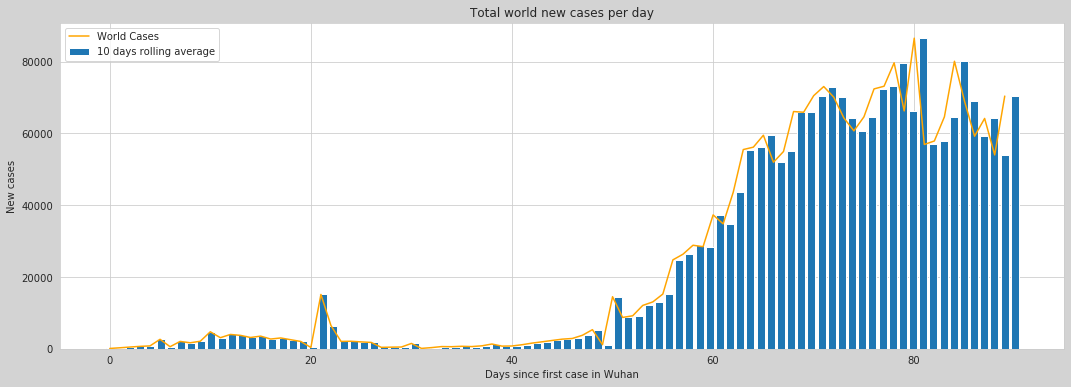

In [234]:
#Bar plot of the new cases
fig = plt.figure(figsize=[18,6])
graph = []
graph2 = []
for time in range(len(country_data.columns)-1):
    value = 0
    for country in allData.index:
        toplot = (country_data.loc[country,country_data.columns[time+1]]-country_data.loc[country,country_data.columns[time]])
        value = value  + toplot
    graph.append(value)
date = pd.date_range(start="2020-02-22",end="2020-04-16")
plt.bar(np.linspace(0,len(graph),len(graph)),np.asarray(graph))
plt.title('Total world new cases per day')
fig.set_facecolor('lightgrey')
plt.ylabel('New cases')
plt.xlabel('Days since first case in Wuhan')
plt.legend('World Cases')
for time in range(len(country_data.columns)-10):
    for country in allData.index:
        for flat in range(0,10):
            toplot = (country_data.loc[country,country_data.columns[time+1+flat]]-country_data.loc[country,country_data.columns[time+flat]])
            value = value  + toplot
        graph2.append(value/10)
plt.plot(graph,color='orange')
plt.legend(['World Cases','10 days rolling average'])
plt.show()

c. Geographical repartion

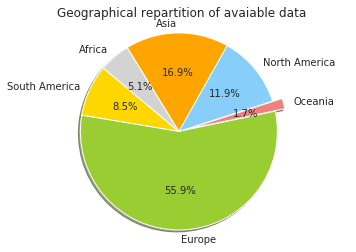

In [235]:
Continents = allData.loc[:,'Continent'].unique()
count = []
for continent in Continents:
    condObj = allData.apply(lambda x: True if x['Continent'] == continent else False, axis =1)
    count.append(len(condObj[condObj == True].index))
    

# Data to plot
labels = Continents
sizes = count
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','orange','lightgrey']
explode = (0, 0, 0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Geographical repartition of avaiable data')
plt.axis('equal')
plt.show()

d. scatter plots

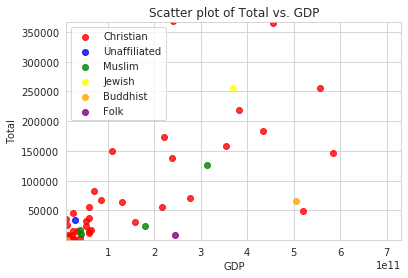

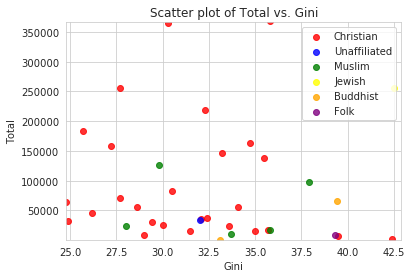

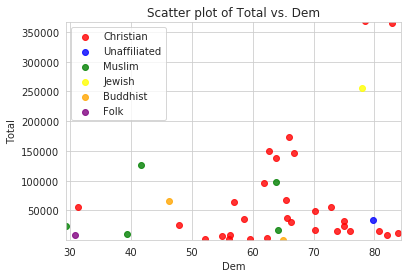

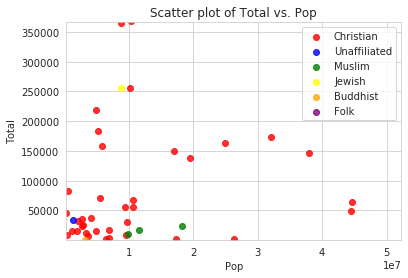

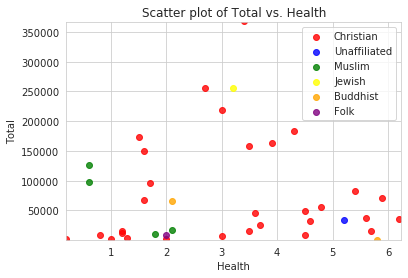

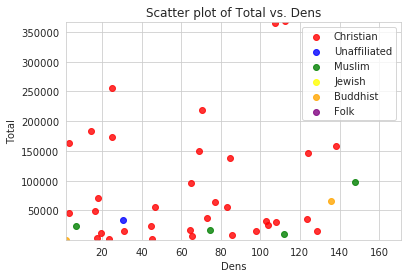

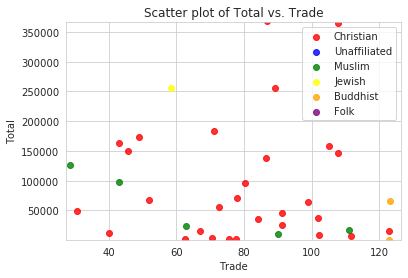

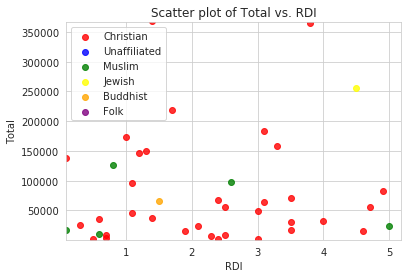

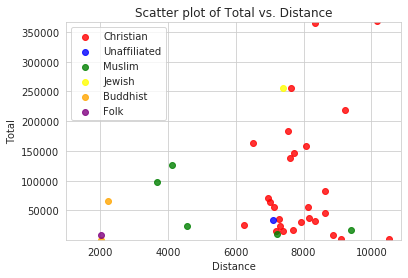

In [236]:
def plot_scatter_size(allData, cols, shape_col = 'Main Religion',
                            size_mul = 0.000025, col_y = 'Total', alpha = 0.2):
    colors = ['red', 'blue', 'green', 'yellow', 'orange','purple'] # pick distinctive shapes
    unique_cats = allData[shape_col].unique()
    for col in cols: # loop over the columns to plot
        sns.set_style("whitegrid")
        for i, cat in enumerate(unique_cats): # loop over the unique categories
            temp = allData[allData[shape_col] == cat]
            sns.regplot(col, col_y, data=temp, color = colors[i], label = cat, 
                        fit_reg = False)
        plt.xlim(allData[col].min(),allData[col].quantile(0.8))
        plt.ylim(allData['Total'].min(),allData['Total'].quantile(0.8))
        plt.title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.legend()
        plt.show()

plot_scatter_size(allData, num_cols)  

### Splitting the predictors and target

In [241]:
y = allData.drop(['GDP', 'Gini', 'Dem', 'Pop', 'Health',
                  'Dens', 'Trade','Continent','RDI','Main Religion','Distance'],axis = 1)

X = allData.loc[:,['GDP', 'Gini', 'Dem', 'Pop', 'Health',
                  'Dens', 'Trade','RDI','Main Religion','Continent','Distance']]


X = X.replace(X.loc[:,'Main Religion'].unique(),[0,1,2,3,4,5])
X = X.replace(X.loc[:,'Continent'].unique(),[0,1,2,3,4,5])
X

,GDP,Gini,Dem,Pop,Health,Dens,Trade,RDI,Main Religion,Continent,Distance
Country/Region,,,,,,,,,,,
Argentina,5.198715e+11,44.5,70.2,4.449450e+07,4.50,16.258510,30.700446,3.0,0,0,19511.435563
Armenia,1.243309e+10,30.0,47.9,2.951776e+06,3.70,103.680225,91.288962,0.3,0,1,6239.009961
Australia,1.433904e+12,34.7,90.9,2.498269e+07,3.90,3.249129,43.192261,5.6,0,2,6504.224626
Austria,4.552858e+11,30.3,82.9,8.840521e+06,7.70,107.206927,107.790262,3.8,0,1,8344.431208
Belarus,5.966250e+10,28.6,31.3,9.483499e+06,11.50,46.728800,139.343480,4.7,0,1,7125.982782
Belgium,5.427611e+11,28.4,77.8,1.143326e+07,6.50,377.214927,165.314652,5.7,0,1,8678.036369
Bulgaria,6.513295e+10,35.7,70.3,7.025037e+06,6.50,64.703537,131.250967,3.5,0,1,7693.736538
Canada,1.713342e+12,33.6,91.5,3.705776e+07,2.70,4.075308,66.223971,5.3,0,3,9149.902492
China,1.360815e+13,43.7,33.2,1.392730e+09,3.56,148.348833,38.246154,7.3,1,4,998.060041


### Finding first cases

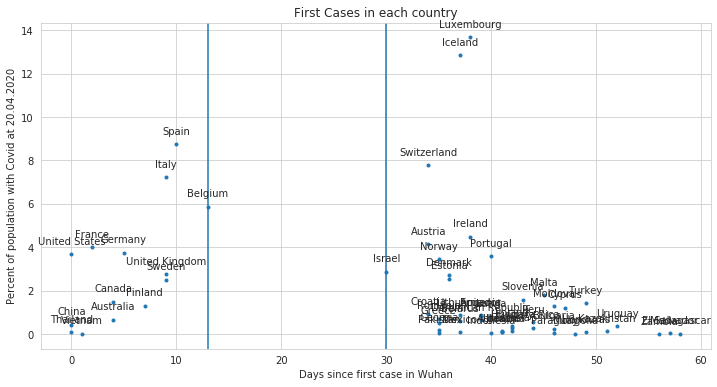

In [242]:
# Finding first case
nonZero = []
for country in y.index:
    for date in y.columns:
        if y.loc[country,date] != 0:
            index = y.columns.get_loc(date)
            nonZero.append(index)
            break
frac = y.iloc[:,-1]/X.loc[:,'Pop']*100
fig = plt.figure(figsize=[12,6])
plt.plot(nonZero,frac,'.')
plt.title('First Cases in each country')
plt.xlabel('Days since first case in Wuhan')
plt.ylabel('Percent of population with Covid at 20.04.2020')

count = 0
for x,z in zip(nonZero,frac):
    
    label = y.index[count]

    plt.annotate(label, # this is the text
                 (x,z), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    count += 1
plt.axvline(x = 13)
plt.axvline(x = 30)
plt.show()

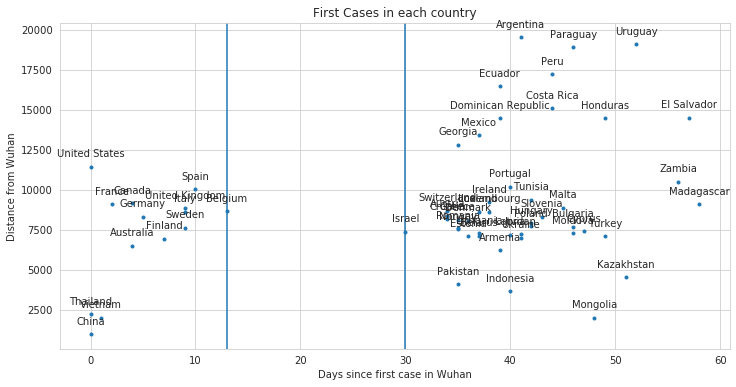

In [244]:
# Finding first case
nonZero = []
for country in y.index:
    for date in y.columns:
        if y.loc[country,date] != 0:
            index = y.columns.get_loc(date)
            nonZero.append(index)
            break
fig = plt.figure(figsize=[12,6])
plt.plot(nonZero,allData['Distance'],'.')
plt.title('First Cases in each country')
plt.xlabel('Days since first case in Wuhan')
plt.ylabel('Distance from Wuhan in km')

count = 0
for x,z in zip(nonZero,allData['Distance']):
    
    label = y.index[count]

    plt.annotate(label, # this is the text
                 (x,z), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    count += 1
plt.axvline(x = 13)
plt.axvline(x = 30)
plt.show()

In [17]:
# Splitting the data
RanInd = np.random.permutation(y.index)
frac = y.iloc[:,-1]/X.loc[:,'Pop']*100
y_train = frac.loc[RanInd[0:40]]
y_test = frac.loc[RanInd[41:-1]]
x_train = X.loc[RanInd[0:40],:]
x_test = X.loc[RanInd[41:-1],:]

# Import Gaussian Process 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression

# Predicting the value
LR = LinearRegression()
LR.fit(x_train,y_train)
y_predict = LR.predict(x_test)

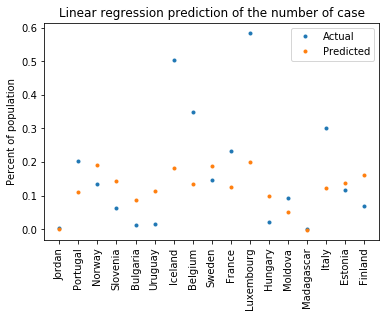

In [18]:
# Plot of linear regression prediction
plt.plot(RanInd[41:-1],y_test,'.')
plt.plot(RanInd[41:-1],y_predict,'.')
plt.legend(['Actual','Predicted'])
plt.xticks(rotation = 90)
plt.title('Linear regression prediction of the number of case')
plt.ylabel('Percent of population')
plt.show()